In [ ]:
import math
import torch
import torch.nn as nn
import numpy as np
import torch.nn.init as init
import matplotlib.pyplot as plt

### 建立block

In [2]:
class Block(nn.Module):
    def __init__(self, in_ch,out_ch, kernel_size=3, padding=1, stride=1):
        super(Block, self).__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, kernel_size=kernel_size, padding=padding, stride=stride)
        self.bn1 = nn.BatchNorm2d(out_ch)
        self.relu1 = nn.ReLU(inplace=True)
    def forward(self, x):
        out = self.relu1(self.bn1(self.conv1(x)))
        return out

In [3]:
class ResBlock(nn.Module):
    def __init__(self, in_ch,out_ch, kernel_size=3, padding=1, stride=1):
        super(ResBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_ch)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_ch, out_ch, kernel_size=kernel_size, padding=padding, stride=stride)
    def forward(self, x):
        out = self.conv1(self.relu1(self.bn1(x)))
        return out

In [4]:
class Bottleneck(nn.Module):
    expansion = 4
    def __init__(self, in_chans, out_chans):
        super(Bottleneck, self).__init__()
        assert out_chans%4==0
        self.block1 = ResBlock(in_chans, int(out_chans/4), kernel_size=1, padding=0)
        self.block2 = ResBlock(int(out_chans/4), int(out_chans/4), kernel_size=3, padding=1)
        self.block3 = ResBlock(int(out_chans/4), out_chans, kernel_size=1, padding=0)
        
    def forward(self, x):
        identity = x
        out = self.block1(x)
        out = self.block2(out)
        out = self.block3(out)
        out += identity
        return out

    
class Bottleneck1(nn.Module):
    expansion = 4
    def __init__(self, in_chans, out_chans):
        super(Bottleneck1, self).__init__()
        assert out_chans%4==0
        self.block1 = ResBlock(in_chans, int(out_chans/4), kernel_size=1, padding=0)
        self.block2 = ResBlock(int(out_chans/4), int(out_chans/4), kernel_size=3, padding=1)
        self.block3 = ResBlock(int(out_chans/4), out_chans, kernel_size=1, padding=0)
        self.conv1 = ResBlock(in_chans, out_chans, kernel_size=1, padding=0)
        
    def forward(self, x):
        identity = x
        identity = self.conv1(identity)
        out = self.block1(x)
        out = self.block2(out)
        out = self.block3(out)
        out += identity
        return out
    
class DownBottleneck(nn.Module):
    expansion = 4
    def __init__(self, in_chans, out_chans):
        super(DownBottleneck, self).__init__()
        assert out_chans%4==0
        self.block1 = ResBlock(in_chans, int(out_chans/4), kernel_size=1, padding=0, stride=2)
        self.conv1 = nn.Conv2d(in_chans, out_chans, kernel_size=1, padding=0, stride=2)
        self.block2 = ResBlock(int(out_chans/4), int(out_chans/4), kernel_size=3, padding=1)
        self.block3 = ResBlock(int(out_chans/4), out_chans, kernel_size=1, padding=0)
        
    def forward(self, x):
        identity = self.conv1(x)
        out = self.block1(x)
        out = self.block2(out)
        out = self.block3(out)
        out += identity
        return out


### 建立layer

In [5]:
def make_layers(in_channels, layer_list,name="vgg"):
    layers = []
    if name=="vgg":
        for v in layer_list:
            layers += [Block(in_channels, v)]
            in_channels = v
    elif name=="resnet":
        layers += [DownBottleneck(in_channels, layer_list[0])]
        in_channels = layer_list[0]
        for v in layer_list[1:]:
            layers += [Bottleneck(in_channels, v)]
            in_channels = v
    return nn.Sequential(*layers)
            

class Layer(nn.Module):
    def __init__(self, in_channels, layer_list ,net_name):
        super(Layer, self).__init__()
        self.layer = make_layers(in_channels, layer_list, name=net_name)
    def forward(self, x):
        out = self.layer(x)
        return out

### 建立VGG-19BN--encode模型

* 'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
* 'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
* 'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
* 'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],

In [6]:
class VGG(nn.Module):
    '''
    VGG model 
    '''
    def __init__(self):
        super(VGG, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=100)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu1 = nn.ReLU(inplace=True)
        self.layer1 = Layer(64, [64], "vgg")
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.layer2 = Layer(64, [128, 128], "vgg")
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.layer3 = Layer(128, [256, 256, 256, 256], "vgg")
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.layer4 = Layer(256, [512, 512, 512, 512], "vgg")
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.layer5 = Layer(512, [512, 512, 512, 512], "vgg")
        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)
    def forward(self, x):
        f0 = self.relu1(self.bn1(self.conv1(x)))
        f1 = self.pool1(self.layer1(f0))
        f2 = self.pool2(self.layer2(f1))
        f3 = self.pool3(self.layer3(f2))
        f4 = self.pool4(self.layer4(f3))
        f5 = self.pool5(self.layer5(f4))
        return [f3, f4, f5]

### 建立Resnet101--encode模型

### 上采样模块的权重初始化

In [7]:
def bilinear_kernel(in_channels, out_channels, kernel_size):
    factor = (kernel_size + 1) // 2
    
    center = kernel_size/2
    og = np.ogrid[:kernel_size, :kernel_size]
    filt = (1 - abs(og[0] - center) / factor) * (1 - abs(og[1] - center) / factor)
    weight = np.zeros((in_channels, out_channels, kernel_size, kernel_size), dtype='float32')
    weight[range(in_channels), range(out_channels), :, :] = filt
    return torch.from_numpy(weight)

(450, 615, 3)
(900, 1230, 3)


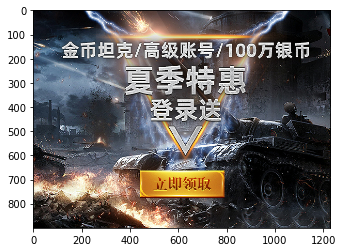

In [8]:
x = plt.imread("1.jpg")
print(x.shape)
x = torch.from_numpy(x.astype('float32')).permute(2, 0, 1).unsqueeze(0)
conv_trans = nn.ConvTranspose2d(3, 3, 4, 2, 1)
# 将其定义为 bilinear kernel
conv_trans.weight.data = bilinear_kernel(3, 3, 4)
y = conv_trans(x).data.squeeze().permute(1, 2, 0).numpy()
plt.imshow(y.astype('uint8'))
print(y.shape)

### 建立上采样模块

### 建立VGG_19bn_8s模型

In [9]:
class VGG_19bn_8s(nn.Module):
    def __init__(self, n_class):
        super(VGG_19bn_8s, self).__init__()
        self.encode = VGG()
        
        self.fc6 = nn.Conv2d(512, 4096, 7) # padding=0
        self.relu6 = nn.ReLU(inplace=True)
        self.drop6 = nn.Dropout2d()

        self.fc7 = nn.Conv2d(4096, 4096, 1)
        self.relu7 = nn.ReLU(inplace=True)
        self.drop7 = nn.Dropout2d()

        self.score_fr = nn.Conv2d(4096, n_class, 1)
        self.trans_p3 = nn.Conv2d(256, n_class, 1)
        self.trans_p4 = nn.Conv2d(512, n_class, 1)

        self.up2time = nn.ConvTranspose2d(
            n_class, n_class, 4, stride=2, bias=False)
        self.up4time = nn.ConvTranspose2d(
            n_class, n_class, 4, stride=2, bias=False)
        self.up32time = nn.ConvTranspose2d(
            n_class, n_class, 16, stride=8, bias=False)
        for m in self.modules():
            if isinstance(m, nn.ConvTranspose2d):
                m.weight.data = bilinear_kernel(n_class, n_class, m.kernel_size[0])
    def forward(self, x):
        feature_list = self.encode(x)
        p3, p4 ,p5 = feature_list
        f6 = self.drop6(self.relu6(self.fc6(p5)))
        f7 = self.score_fr(self.drop7(self.relu7(self.fc7(f6))))
        
        up2_feat = self.up2time(f7)
        h = self.trans_p4(p4)
        h = h[:, :, 5:5 + up2_feat.size()[2], 5:5 + up2_feat.size()[3]]
        h = h+up2_feat
        
        up4_feat = self.up4time(h)
        h = self.trans_p3(p3)
        h = h[:, :, 9:9 + up4_feat.size()[2], 9:9 + up4_feat.size()[3]]
        h = h+up4_feat
        
        h = self.up32time(h)
        final_scores = h[:, :, 31:31 + x.size()[2], 31:31 + x.size()[3]].contiguous()
        
        return final_scores
        
        

In [10]:
class ResNet101(nn.Module):
    '''
    ResNet101 model 
    '''
    def __init__(self):
        super(ResNet101, self).__init__()
        self.conv1 = Block(3, 64, 7, 3, 2)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.conv2_1 =Bottleneck1(64, 256)
        self.conv2_2 =Bottleneck(256, 256)
        self.conv2_3 =Bottleneck(256, 256)
        self.layer3 = Layer(256, [512, 512, 512, 512], "resnet")
        self.layer4 = Layer(512, [1024]*23, "resnet")
        self.layer5 = Layer(1024, [2048]*3, "resnet")
    def forward(self, x):
        f1 = self.conv1(x)
        f2 = self.conv2_3(self.conv2_2(self.conv2_1(self.pool1(f1))))
        f3 = self.layer3(f2)
        f4 = self.layer4(f3)
        f5 = self.layer5(f4)
        return [f3, f4, f5]


In [11]:
class Resnet101_8s(nn.Module):
    def __init__(self, n_class):
        super(Resnet101_8s, self).__init__()
        self.encode = ResNet101()

        self.score_fr = nn.Conv2d(2048, n_class, 1)
        self.trans_p3 = nn.Conv2d(512, n_class, 1)
        self.trans_p4 = nn.Conv2d(1024, n_class, 1)
        self.smooth_conv1 = nn.Conv2d(n_class, n_class, 3, padding=1)
        self.smooth_conv2 = nn.Conv2d(n_class, n_class, 3, padding=1)

        self.up2time = nn.ConvTranspose2d(
            n_class, n_class, 2, stride=2, bias=False)
        self.up4time = nn.ConvTranspose2d(
            n_class, n_class, 2, stride=2, bias=False)
        self.up32time = nn.ConvTranspose2d(
            n_class, n_class, 8, stride=8, bias=False)
        
    def forward(self, x):
        feature_list = self.encode(x)
        p3, p4 ,p5 = feature_list
        
        f7 = self.score_fr(p5)
        up2_feat = self.up2time(f7)
        
        h = self.trans_p4(p4)
        h = h+up2_feat
        h = self.smooth_conv1(h)
        
        up4_feat = self.up4time(h)
        h = self.trans_p3(p3)
        h = h+up4_feat
        h = self.smooth_conv2(h)
        
        final_scores = self.up32time(h)
        return final_scores

In [12]:
x = torch.randn((1,3, 256,256))

In [13]:
fcn_resnet = Resnet101_8s(21)

In [14]:
model = VGG_19bn_8s(21)

In [15]:
model.eval()
y_vgg = model(x)

In [16]:
fcn_resnet.eval()
y_resnet = fcn_resnet(x)

In [17]:
y_vgg.size()

torch.Size([1, 21, 256, 256])

In [18]:
y_resnet.size()

torch.Size([1, 21, 256, 256])

In [14]:
from torchsummary import summary

In [15]:
summary(model, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 454, 454]           1,792
       BatchNorm2d-2         [-1, 64, 454, 454]             128
              ReLU-3         [-1, 64, 454, 454]               0
            Conv2d-4         [-1, 64, 454, 454]          36,928
       BatchNorm2d-5         [-1, 64, 454, 454]             128
              ReLU-6         [-1, 64, 454, 454]               0
             Block-7         [-1, 64, 454, 454]               0
             Layer-8         [-1, 64, 454, 454]               0
         MaxPool2d-9         [-1, 64, 227, 227]               0
           Conv2d-10        [-1, 128, 227, 227]          73,856
      BatchNorm2d-11        [-1, 128, 227, 227]             256
             ReLU-12        [-1, 128, 227, 227]               0
            Block-13        [-1, 128, 227, 227]               0
           Conv2d-14        [-1, 128, 2